Notes: Change diagram number of qubits

<div style="font-family: 'Times New Roman'; font-size: 16px;">

# Quantum Linear Algebra
The Harrow–Hassidim–Lloyd (HHL) algorithm [Project 1]  
*By Sonny Lowe, David Lee, Arav Raval*

</div>


<div style="font-family: 'Times New Roman'; font-size: 16px;">

This notebook will discuss the Harrow-Hassidim-Lloyd (HHL) quantum algorithm, meant for solving a linear system
$$A\vec{x}=\vec{b} \text{ ,  where } A \text{ is a hermitian matrix}$$
and where $\vec{x}$ and $\vec{b}$ ultimately represent quantum states $\ket{x}$ and $\ket{b}$ respectively. We will provide a derivation, implementation, generalization to non-hermitian matrices, as well as the context for HHL as a subroutine.

Note: we will generally be working in the normalized domain.
</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 1: Mathematical Derivation
 
Our problem is represented as 
$$A\ket{x} = \ket{b}$$
where $\ket{b} \in \mathbb{C}^N$ is some given quantum state and $A \in \mathbb{C}^{N\times N}$. Our goal is to solve for $\ket{x} \in \mathbb{C}^N$ under a few conditions:
- $A$ is hermitian such that $A = A^\dagger$
- $A$ is $s$-sparse and well conditioned, meaning it has at most $s$ nonzero entries per row and its condition number  $\kappa(A)$ is relatively small such that the system is stable and less sensitive to perturbations.
We will break down the derivation into several steps.
- We have access to an "oracle" of A in that we have its eigenvalues to use in our circuit (potential weakness).
- We assume there exists some efficient algorithm to prepare $\ket{b}$

<br>

#### **1. Rewriting and Initialization**
Given that $A$ is a hermitian matrix, there exists a spectral decomposition such that the matrix can be diagonalized by unitary transformations.
$$A = UDU^T,\quad \text{ where } U \text{ is a unitary matrix and } D \text{ is diagonal composed of the real eigenvalues of } A$$
Since the columns of $U$ form an orthonormal basis and are the eigenvalues, we can rewrite this decomposition where $\ket{u_{j}}$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$ as:
$$A = \sum_{i=0}^{N-1}\lambda_{i}\ket{u_{i}}\bra{u_{i}}, \quad \lambda_{i}\in\mathbb{ R }$$
Likewise, as a linear transformation, we can write our resultant vector $\ket{b}$ in the eigenbasis of $A$.
$$\ket{b} = \sum_{i=0}^{N-1}b_{i}\ket{u_{i}}, \quad b_{i}\in\mathbb{ C }$$
Thus, our problem can now be rewritten as:
$$\ket{x} = A^{-1}\ket{b} = \sum_{i=0}^{N-1}\frac{1}{\lambda_{i}}b_{i}\ket{u_{i}}\bra{u_{i}}u_{i}\rangle = \sum_{i=0}^{N-1}\frac{1}{\lambda_{i}}b_{i}\ket{u_{i}}$$

Moreover, note that to represent a state vector $\ket{b}$ of dimension $N$, to prepare it as a quantum register, we prepare it in binary basis using $\log_2{N}$ qubits. Therefore, from here on, $N = \log_2{N}$.

<br>

#### **2. Quantum Phase Estimation**
The problem first boils down to being able to decompose a matrix to find its eigenvalues and eigenvectors in a computationally efficient manner. At a high level, Quantum Phase Estimation is a procedure that performs a series of controlled-$U$ gates given some unitary matrix $U$ with eigenvalues of the form $e^{2\pi i \theta}$, and finds $\theta$

The number of qubits required for QPE is defined by the required additive error epsilon $\epsilon$, where we will set $n_q = O(\log{\frac{1}{\epsilon}})$ representing the number of qubits needed.

For HHL, first, we start with two registers $\ket{0}^{\otimes n_q}$ and $\ket{b}$. Our initial state is thus $\ket{\Phi_0} = \ket{0}^{\otimes n_q} \otimes \ket{b}.$ Then we can characterize the behavior of **QPE** as:
$$\textbf{QPE}(U,\ket{0}^{\otimes n_q},\ket{b}) = \textbf{QPE}(U,\ket{0}^{\otimes n_q},\sum_{j=0}^{N-1}b_{j}\ket{u_{j}}) = \sum_{j=0}^{N-1}b_{j} \ket{\lambda_{j}}_{n_q}  \ket{u_{j}}, \quad\text{ for some clever choice of } U$$

We will choose $U = e^{iAt}$ for some constant $t$ such that $U$ is governed by the same eigenvalues of $A$ and we have that, where $\ket{u_{j}}$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$:
$$U = e^{iAt} = \sum_{j=0}^{N-1}e^{i\lambda_{j}t}\ket{u_j}\bra{u_j}$$

>1. First, we hadamard our first register of $\ket{0}^{\otimes n_q}$. $H^{\otimes n_q}\ket{\Phi_0} = \frac{1}{2^{n/2}}(\ket{0} + \ket{1})^{\otimes n_q} \otimes \ket{b}$
>2. Next, we perform a series of $n_q$ controlled-$U$ gates such that for $k = {0, 1,...,n_q-1}$ (notice $|k| = n_q$), we create the gate (where $\ket{k}$ is the k-th qubit in the $n_q$ registrar and t is some evolution time): 
$$CU^{2^k}(\ket{k}, \ket{b}) =_{\text{if} \ket{k}=\ket{1}} \ket{k} \otimes U^{2^k}\ket{b} = \ket{k} \otimes \sum_{j=0}^{N-1}e^{i\lambda_{j}t2^k}b_{j}\ket{u_{j}}\bra{u_{j}}u_{j}\rangle = \ket{k} \otimes \sum_{j=0}^{N-1}e^{i\lambda_{j}t2^k}b_{j}\ket{u_{j}} $$
The composition of all N of these such gates yields the state (with normalization):
$$ \sum_{j=0}^{N-1} \left( \left( \frac{1}{\sqrt{2^{n_q}}} \sum_{k=0}^{n_q-1} e^{i 2^k \lambda_j t} \ket{k} \right) \otimes b_j \ket{u_j} \right)$$
 >3. Consider just our $n_q$ (control) register, which is now superposed through unitary entanglements to the state:
 $$ \frac{1}{\sqrt{2^n}} \sum_{k=0}^{n_q-1} e^{i 2^k \lambda_j t} \ket{k} $$
 $$ \text{where the phase factor is }\quad \lambda_i t = 2\pi\theta $$
 It is clear now that the encoded phase factor we desire (which represents the eigenvalues of $A$), can be extracted through the inverse quantum fourier transform operation. Thus, applying **QFT$^{-1}$** has the following behavior:
 $$\textbf{QTF}^{-1}(\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^{N-1}} e^{i k \lambda_j t} \ket{k}) \mapsto \ket{\theta 2^{n_q}} \quad\text{ which encodes } \theta_j 2^{n_q} = \lambda_j t / 2\pi \quad\Rightarrow \tilde{\lambda_j} = \frac{\lambda_j t 2^{n_q}}{2\pi}$$
 If we set $t=\pi l$ for some constant $l$, we have essentially calculated an approximation of our actual eigenvalues after normalization. We will also assume for simplicity and without significant loss of accuracy that our eigenvalues can be represented in $n_q$ qubits. We will also set $t=\pi$. Thus, for our total state, we are left with:
 $$\sum_{j=0}^{N-1}\ket{\tilde{\lambda_j}}\otimes b_{j}\ket{u_j}$$

<br>

#### **3. Controlled Rotation**
With our new intermediate state $\sum_{j=0}^{N-1}\ket{\tilde{\lambda_{j}}} \otimes b_{j}\ket{u_{j}} = \ket{\tilde{\lambda}} \otimes \ket{b}$ (working in normalized domain), our next problem is to produce the "inverse eigenvalue." We will do this by applying a series of controlled rotations. These rotations will utilize the control register which now encodes the eigenvalues applied onto a new ancilla register that will extract $\frac{1}{\lambda}$. (Checkpoint: by now, we have created 3 registers with a total state of $\ket{\tilde{\lambda}}_{n_q} \otimes \ket{b}_N \otimes \ket{0}_{ancilla}$)

To do this, we will encode the ancilla qubit to the following state:
$$\ket{0}_{ancilla} \mapsto \sum_{j=0}^{N-1} \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\tilde{\lambda_j}}\ket{1}, \quad\text{ where } C < \min_{j}\tilde{\lambda_j}$$
Considering the general state $\ket{\psi} = \cos(\theta/2)\ket{0} + e^{i\phi}\sin(\theta/2)\ket{1}$ allows us to clearly see that $\theta_j = 2\arcsin(C/\tilde{\lambda_j}) \quad \forall j$. We are left with
 $$\sum_{j=0}^{N-1}\ket{\tilde{\lambda_j}}\otimes b_{j}\ket{u_j} \otimes \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\tilde{\lambda_j}}\ket{1}$$

<br>

#### **4. Uncompute**
Next, we want to uncompute our eigenvalue register by applying the dagger of QPE. This consists of first applying QFT, then simplying applying the conditioned inverse of the unitary matrix $U$ followed by hadamards. We are left with a scaled approximation:
 $$\sum_{j=0}^{N-1}\ket{0}\otimes b_{j}\ket{u_j} \otimes \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\lambda_j}\ket{1}$$

<br>

#### **5. Measure Ancillas**
Finall, we will measure the ancilla, which after normalization, yields the post measurement state if our ancillas have the desired outcome of $\ket{1}$ in the form:
$$\sum_{j=0}^{N-1}\frac{1}{\lambda_{j}}b_{j}\ket{u_{j}}\ket{1}_{ancilla}$$
It is here that we see that this process is not deterministic and can fail up to a probability if our ancilla is in $\ket{0}$. Thus, we will repeat the process of steps 2-4 until success (ancilla is $\ket{1}$).

<br>

#### **6. Extracting Answer**
We can see now that our registers hold our solution in the form of $A^{-1}\ket{b}$. However, since the state $\ket{x}$ is determined in our registers as a superposition, we cannot measure the full state in one shot without collapsing it to a single basis state. However, by measuring certain observables, you can gain useful information about the state without fully collapsing it. The quantum expectation value $\bra{x}M\ket{x}$ for a given observable $M$ is useful in the context of a subroutine because it can allow us to:
- obtain information about the solution $\ket{x}$ for instance, the probability distribution of components of $\ket{x}$ in a particular basis).
- Measure a function of the solution, such as a dot product or a norm, which might be useful in applications without needing the full solution.

<br>

#### **Our overall circuit diagram:**
<img src="./assets/schematic-1.png" alt="General Design" width="600" />

</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 2: Generalization to Non-Hermitian
The case where $A \in \mathbb{C}^{N\times N}$ is not hermitian is actually quite easy to resolve. Simply construct a new matrix $C \in \mathbb{C}^{2N \times 2N}$:
$$ C = \begin{bmatrix}0&A\\A^{\dagger}&0\end{bmatrix} $$
Notice that $C$ is immediately hermitian:
$$ C^{\dagger} = \begin{bmatrix}0&A^{\dagger}\\A^{\dagger^{\dagger}}&0\end{bmatrix}^T = \begin{bmatrix}0&A\\A^{\dagger}&0\end{bmatrix} $$
and the properties of sparesness and well conditioning remain relative to this new matrix.

Notice now that our problem changes as such:
$$A\vec{x}=\vec{b} \text{ ,  where } A \text{ is non-hermitian} \quad\Rightarrow\quad C\begin{bmatrix}0\\x\end{bmatrix} = \begin{bmatrix}b\\0\end{bmatrix} \text{ ,  where } C \text{ is a hermitian matrix} $$
</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 3: Sample Implementation

<br>

This project utilizes IBM's Qiskit 
- qiskit == 0.44.2
- qiskit-aer == 0.12.2
- qiskit-terra == 0.25.2.1

</div>

In [230]:
# Some generic python and jupyter imports
import numpy as np
from numpy import pi,sqrt

from qiskit import(QuantumCircuit, execute, Aer, ClassicalRegister, QuantumRegister)
backend_svec = Aer.get_backend('statevector_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')

# Circuit imports
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import QFT

# Visualizations
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt# implementation of a sample case here

In [270]:
def prepare_hhlparams(
        A: np.ndarray,
        b: np.ndarray,
        tol: float,
)-> (np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int):
    if not isinstance(A, np.ndarray) or A.ndim != 2:
        raise TypeError('A must be a 2D numpy matrix')
    elif not isinstance(b, np.ndarray) or b.ndim != 1:
        raise TypeError('b must be a 1D numpy matrix')
    elif A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square matrix.")
    elif A.shape[0] != b.size: 
        raise ValueError("Invalid dimensions for linear system.")
    elif np.linalg.det(A) == 0:
        raise ValueError("A must an invertible matrix.")
    
    # verify matrix sparsity, well conditioned, here
    # do we need that b be normalized as given?
    
    n = len(b)
    nb = int(np.ceil(np.log2(n)))
    nq = int(np.log(1/tol))
    N = 2**nb
    
    # Create C
    A_pad = np.zeros((N,N), dtype=A.dtype)
    A_pad[:n, :n] = A
    # C = np.block([[np.zeros_like(A_pad), A_pad], [np.conj(A_pad.T), np.zeros_like(A_pad)]])
    C = A
    
    # Prepare b
    b_pad = np.pad(b, (0, (C.shape[0]) - len(b)))
    
    t = pi
    eigenvalues, eigenvectors = np.linalg.eigh(C)   
    
    # Create thetas (rotation angles) 
    tilde_eigenvalues = (eigenvalues * t * 2**nq) / (2 * pi)
    C_coeff = np.min(tilde_eigenvalues) - 0.001
    C_over_rescaled_eigenvalues = np.array(C_coeff/tilde_eigenvalues, dtype=complex)
    thetas = 2 * np.arcsin(C_over_rescaled_eigenvalues)
        
    # Create U
    exp_diag = np.diag(np.exp(1j * eigenvalues * t))
    U = eigenvectors @ exp_diag @ eigenvectors.conj().T
    
    print(C_coeff)
        
    # return C, b_pad, U, thetas, 2*nb, nq
    return C, b_pad, U, thetas, nb, nq
    

1.3323333333333334


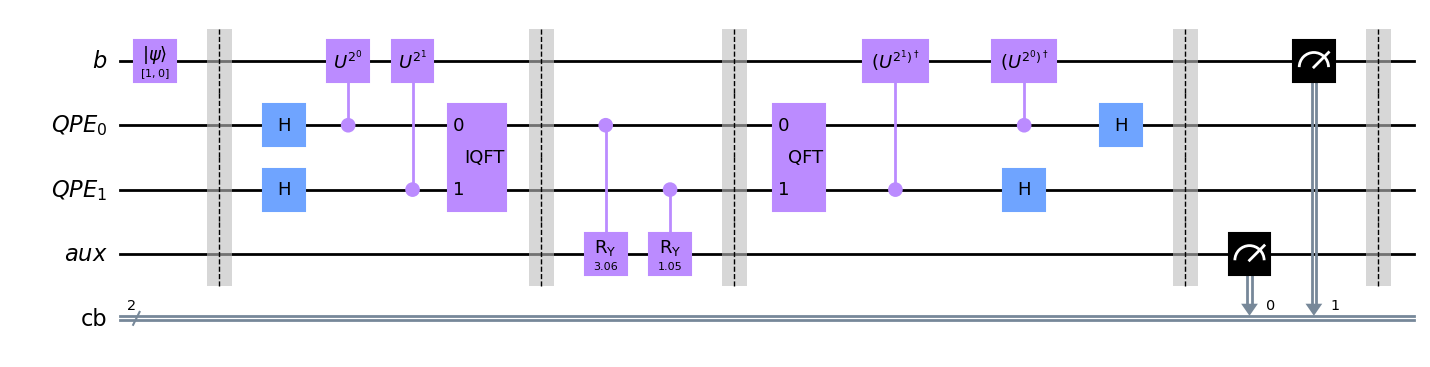

In [271]:
def hhl_circuit(
        A: np.ndarray,
        b: np.ndarray,
        tol: float = 1e-1,
) -> QuantumCircuit:
    """    
    :param A: A numpy matrix 
    :param b: A numpy vector
    :return: A quantum circuit for the hhl algorithm
    """

    A, b, U, thetas, nb, nq = prepare_hhlparams(A, b, tol)
    n_b = QuantumRegister(nb, 'b')
    n_q = QuantumRegister(nq, 'QPE')
    n_a = QuantumRegister(1, 'aux')
    cb = ClassicalRegister(2,'cb')
  
    # INITIALIZATION CIRCUIT
    init_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    init_circ.initialize(b / np.linalg.norm(b), list(range(nb)))
    init_circ.barrier()
    
    # QPE CIRCUIT
    qpe_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    qpe_circ.h(n_q)
    for i in range(nq):
        U_k = np.linalg.matrix_power(U, 2**i)
        label = "$U^{2^" + str(i) + "}$"
        CU_gate = UnitaryGate(U_k, label=label).control(1)
        qpe_circ.append(CU_gate, list(np.concatenate(([nb+i], np.arange(nb)))))
    qpe_circ.append(QFT(nq, inverse=True), n_q)
    qpe_circ.barrier()
    
    # EIGENVALUE ROTATION CIRCUIT
    eigrot_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    for i in range(nq):
        eigrot_circ.cry(thetas[i].real, n_q[i], n_a) 
    eigrot_circ.barrier()
    
    # UNCOMPUTING QPE CIRCUIT
    U_dag = np.conj(U.T)
    qpe_dag_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    qpe_dag_circ.append(QFT(nq, inverse=False), n_q)
    for i in range(nq-1, -1, -1):
        U_dag_k = np.linalg.matrix_power(U_dag, 2**i)
        label = "$(U^{2^" + str(i) + ")^\dagger}$"
        CU_gate = UnitaryGate(U_dag_k, label=label).control(1)
        qpe_dag_circ.append(CU_gate, list(np.concatenate(([nb+i], np.arange(nb)))))
    qpe_dag_circ.h(n_q)
    qpe_dag_circ.barrier()
    
    # MEASURING ANCILLA 
    measure_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    measure_circ.measure(n_a, cb[0])
    measure_circ.measure(n_b, cb[1])
    measure_circ.barrier()
    
    circuit = init_circ.compose(qpe_circ)
    circuit = circuit.compose(eigrot_circ)
    circuit = circuit.compose(qpe_dag_circ)
    circuit = circuit.compose(measure_circ)

    return circuit
    
A = np.array([[1, -1/3],
              [-1/3, 1]], dtype=complex)
b = np.array([1,0], dtype=complex)
hhl = hhl_circuit(A, b)
hhl.draw('mpl')

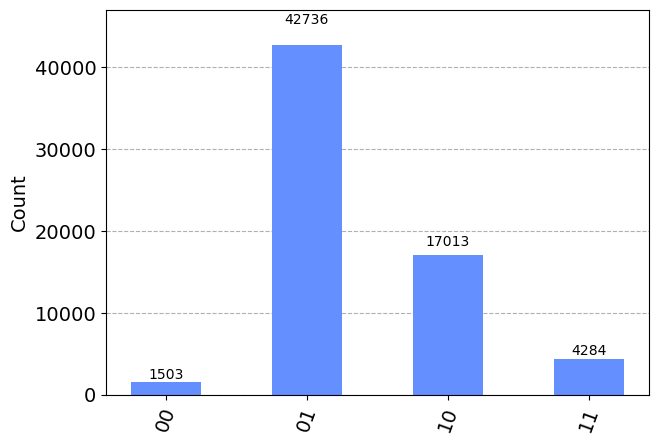

In [272]:
job = execute(hhl, backend=backend_qasm, shots=2**16)
counts = job.result().get_counts()
plot_histogram(counts)

In [142]:
import numpy as np

def generate_unitary_for_qpe(A, t):
    """
    Generate the unitary matrix U = exp(iAt) for QPE.

    :param A: np.ndarray, Hermitian matrix A
    :param t: float, scaling factor
    :return: np.ndarray, unitary matrix U
    """
    # Check if A is Hermitian
    if not np.allclose(A, A.conj().T):
        raise ValueError("Matrix A must be Hermitian.")
    
    # Eigen-decomposition of A
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    
    # Compute e^(i * Lambda * t)
    exp_diag = np.diag(np.exp(1j * eigenvalues * t))
    
    # Compute U = V @ exp_diag @ V^dagger
    U = eigenvectors @ exp_diag @ eigenvectors.conj().T
    
    return U

# Example usage:
A = np.array([[3/4, 1/4],
              [1/4, 3/4]], dtype=complex)
t = np.pi
U = generate_unitary_for_qpe(A, t)
print("Unitary matrix U:\n", U)


Unitary matrix U:
 [[-0.5+0.5j -0.5-0.5j]
 [-0.5-0.5j -0.5+0.5j]]


<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 4: Subroutines

</div>

In [5]:
# implementation of subroutines